In [1]:

import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
ps = PorterStemmer()
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from sklearn import svm
import itertools
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import tqdm
import contractions
from bs4 import BeautifulSoup
import unicodedata
import gensim

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder




[nltk_data] Downloading package punkt to /Users/pankaagr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pankaagr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pankaagr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.
/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (t

In [2]:
df = pd.read_csv('train.tsv',sep='\t')

In [3]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [5]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [6]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [7]:
df.Sentiment.value_counts().sort_values(ascending=False).iplot(kind='bar',yTitle='Number of reviews')

In [8]:
#text Pre-Processing
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: a modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub(' ',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['Phrase'] = df['Phrase'].apply(clean_text)
df['Phrase'] = df['Phrase'].str.replace('\d+','')

In [9]:
#some more text-PreProcessing
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

Phrase_reviews = df['Phrase'].values
norm_phrases = pre_process_corpus(Phrase_reviews)

  0%|          | 0/156060 [00:00<?, ?it/s]/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/bs4/__init__.py:302: UserWarning:

"b'movies'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

  1%|          | 1944/156060 [00:00<00:16, 9241.92it/s]/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/bs4/__init__.py:302: UserWarning:

"b'music'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

  3%|▎         | 4750/156060 [00:00<00:16, 9039.60it/s]/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/bs4/__init__.py:302: UserWarning:

"b'pictures'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

  4%|▎         | 5570/156060 [00:00<00:17, 8768.80it/s]/Users/pankaagr/anaconda3/envs/newenvt/lib/python3.6/site-packages/bs4/__init__.py:302: UserWarning:



In [10]:
df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


In [11]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [12]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [13]:
#To prepare text data for our deep learning model, we transform each review into a sequence. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

#To perform this transformation, keras provides the Tokenizer
t = Tokenizer(oov_token = '<UNK>')
#Fit on data
t.fit_on_texts(norm_phrases)
t.word_index['<PAD>'] = 0

In [14]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('harmlessly', 14999), ('<PAD>', 0), 1)

In [15]:
sequences = t.texts_to_sequences(norm_phrases)

In [16]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Document size={}".format(t.document_count))

Vocabulary size=15000
Document size=156060


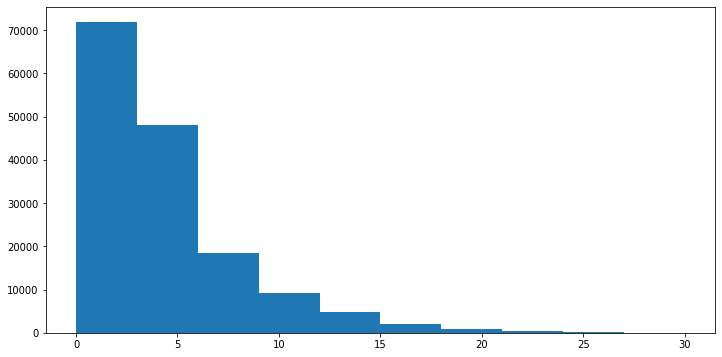

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

sequences_lens = [len(s) for s in sequences]

fig,ax = plt.subplots(1, figsize=(12, 6))
h1 = ax.hist(sequences_lens)


In [18]:
#Sequence Normalization
#Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated
#from keras.utils.np_utils import to_categorical
from keras.utils.np_utils import to_categorical

MAX_SEQUENCE_LENGTH = 1000

X = sequence.pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)
y = to_categorical(df.Sentiment)
VOCAB_SIZE = len(t.word_index)
X.shape,y.shape

((156060, 1000), (156060, 5))

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, y_train.shape

((124848, 1000), (124848, 5))

In [20]:
X_test.shape,y_test.shape

((31212, 1000), (31212, 5))

In [21]:
#Prepare the Model
#Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [22]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32,kernel_size=4,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         4500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 128)         153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 32)           8224      
_________________________________________________________________
max_

In [23]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Train on 112363 samples, validate on 12485 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
112363/112363 [==============================] - 2322s 21ms/sample - loss: 1.0211 - acc: 0.5919 - val_loss: 0.8612 - val_acc: 0.6505
Epoch 2/2
112363/112363 [==============================] - 2286s 20ms/sample - loss: 0.7809 - acc: 0.6803 - val_loss: 0.8324 - val_acc: 0.6662


In [24]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

31212/31212 [==============================] - 220s 7ms/sample - loss: 0.8382 - acc: 0.6628
Accuracy: 66.28%
